Early stopping at epoch 8


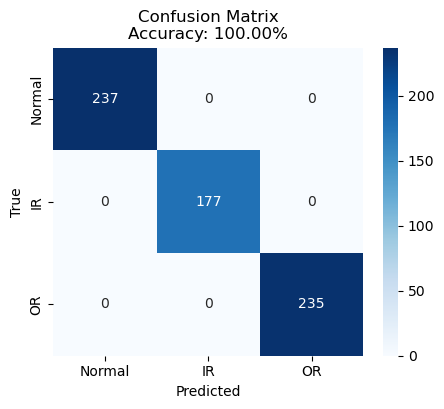

 - Model accuracy: 100.00%


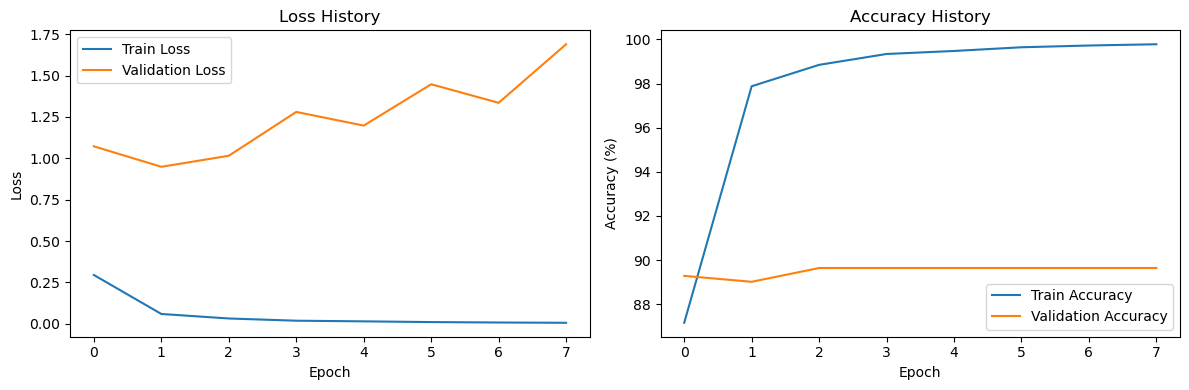

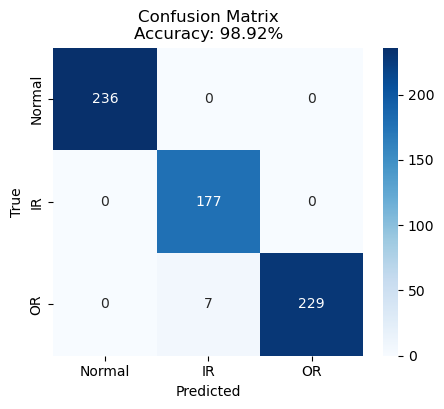

 - Model accuracy: 98.92%


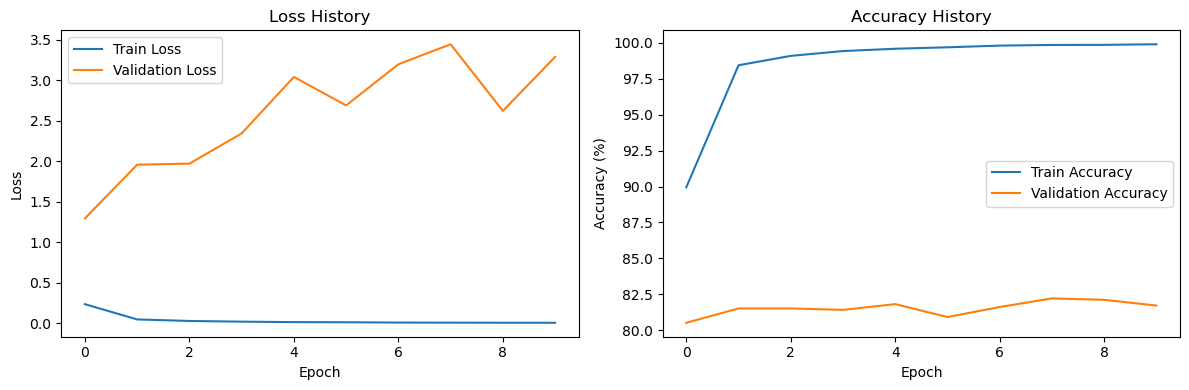

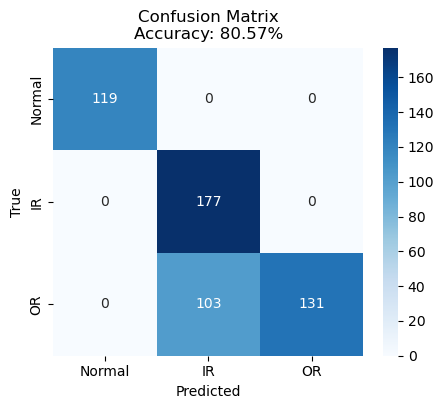

 - Model accuracy: 80.57%


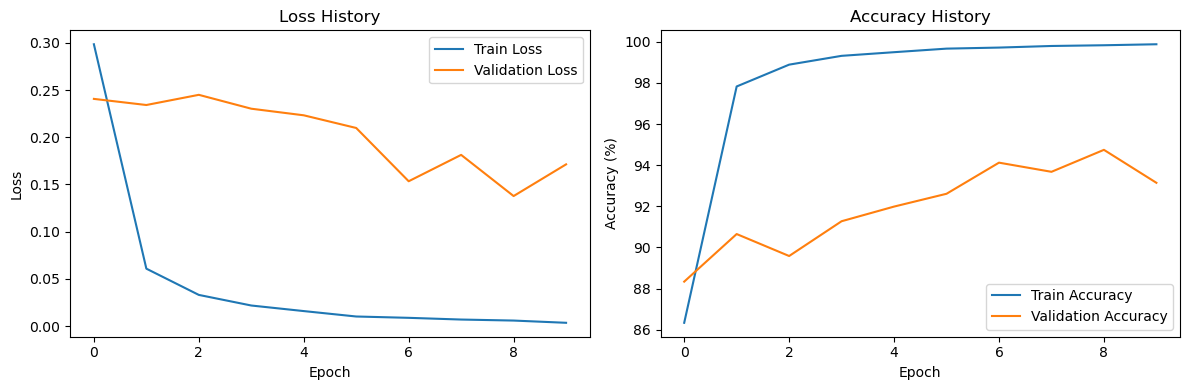

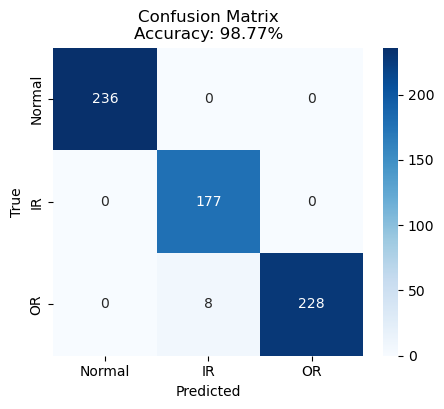

 - Model accuracy: 98.77%


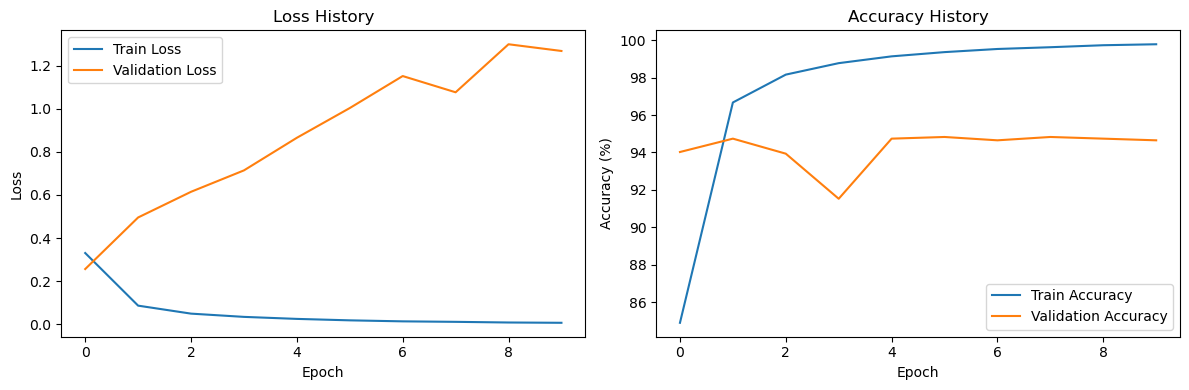

Early stopping at epoch 10


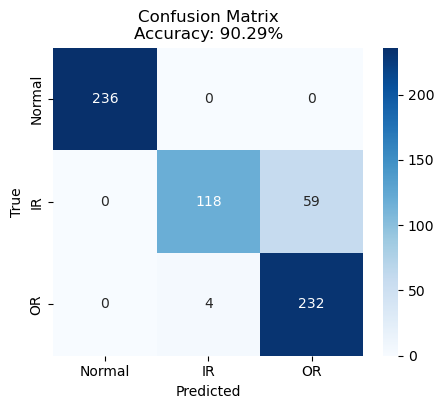

 - Model accuracy: 90.29%


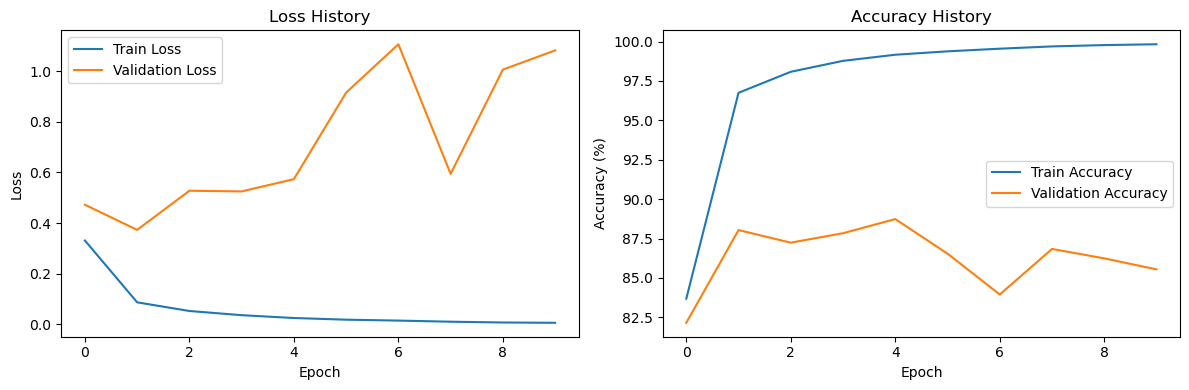

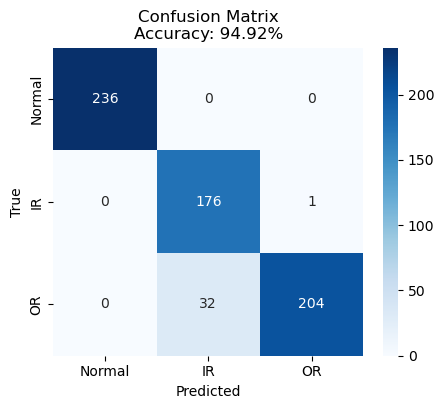

 - Model accuracy: 94.92%


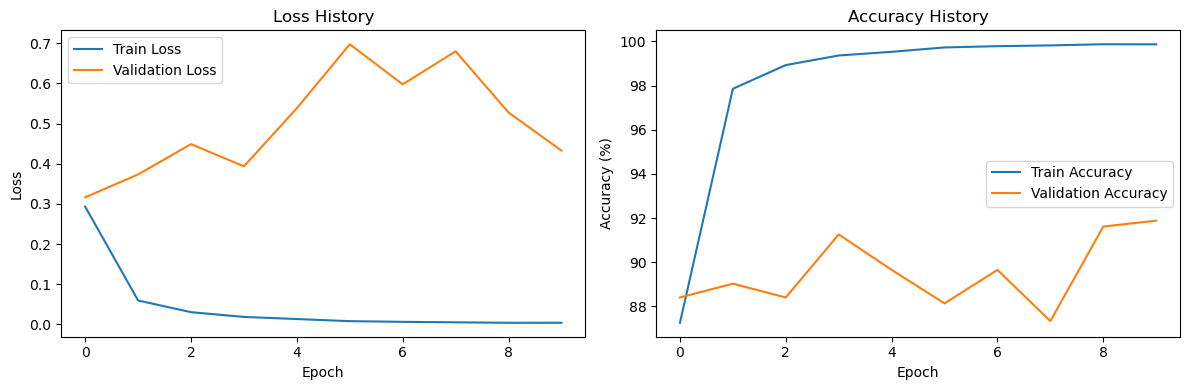

Early stopping at epoch 7


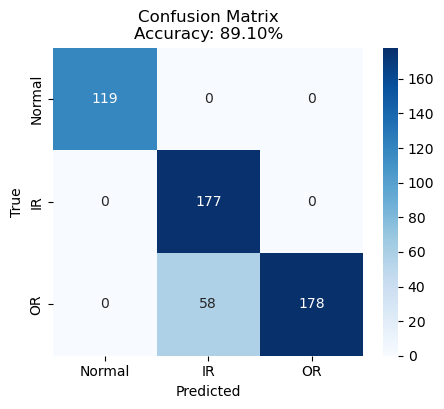

 - Model accuracy: 89.10%


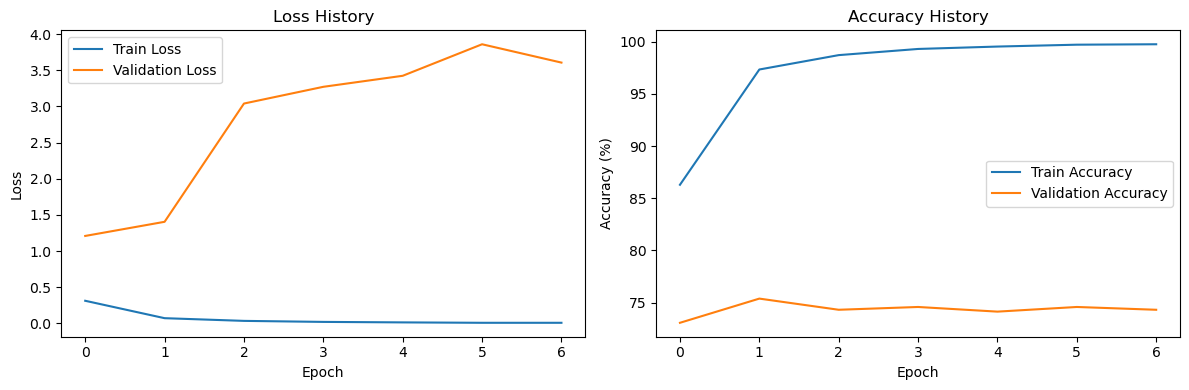

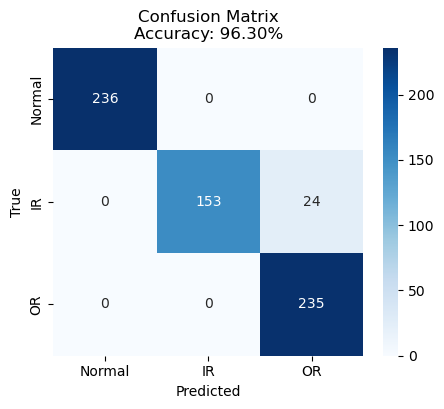

 - Model accuracy: 96.30%


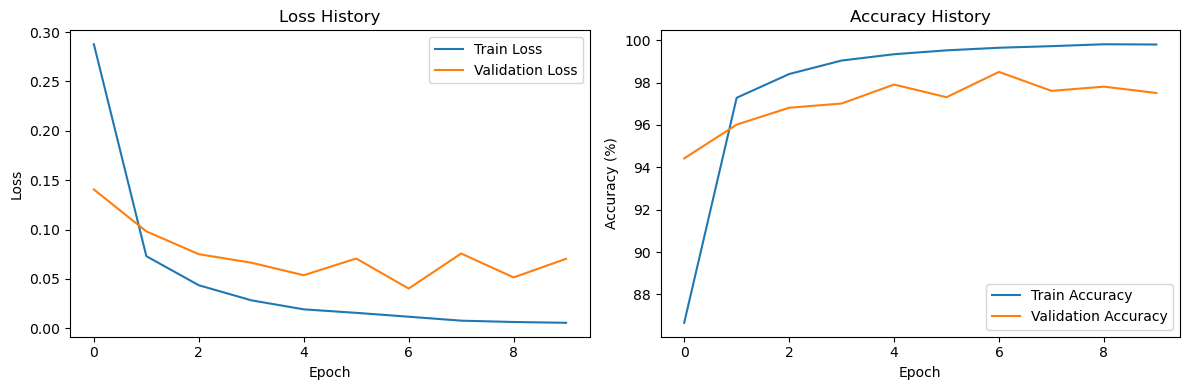

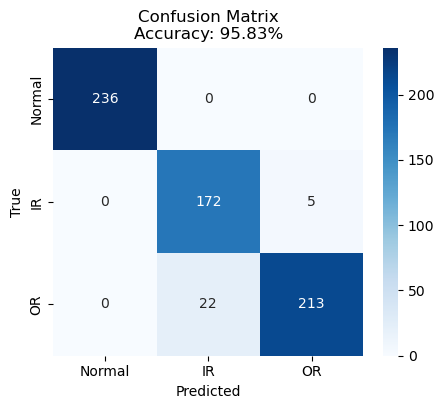

 - Model accuracy: 95.83%


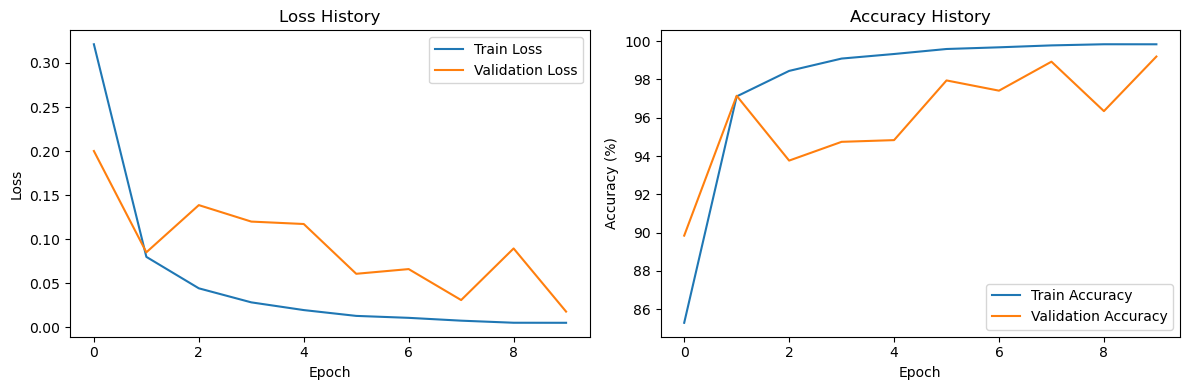

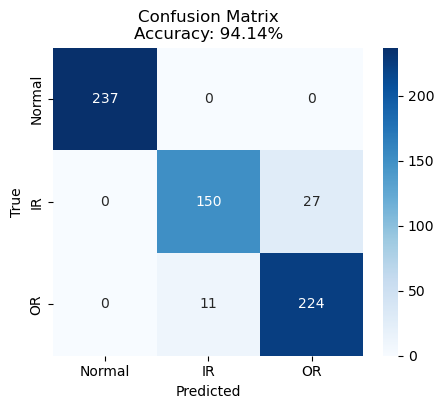

 - Model accuracy: 94.14%


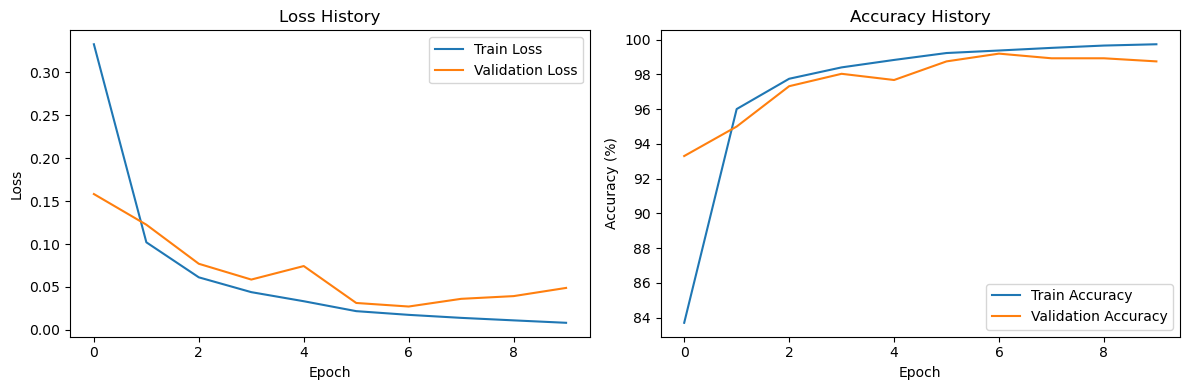

Early stopping at epoch 10


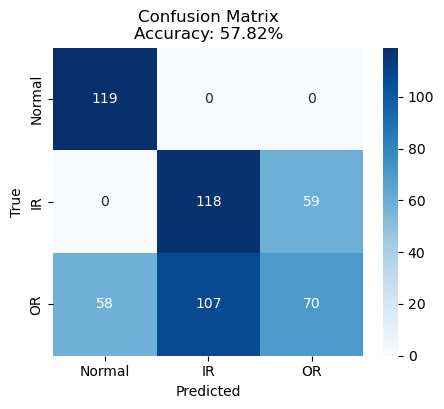

 - Model accuracy: 57.82%


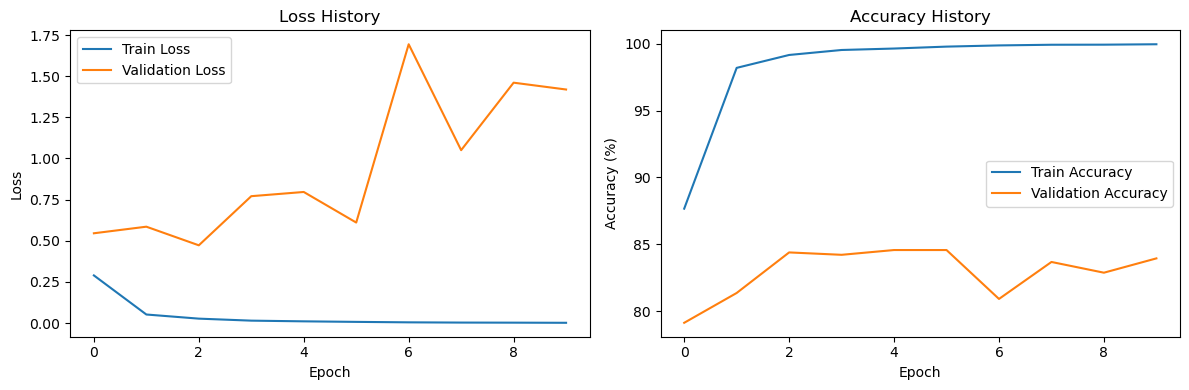

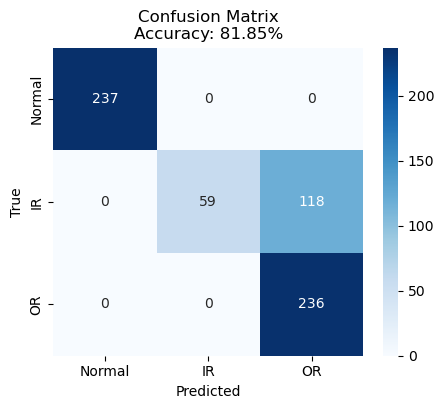

 - Model accuracy: 81.85%


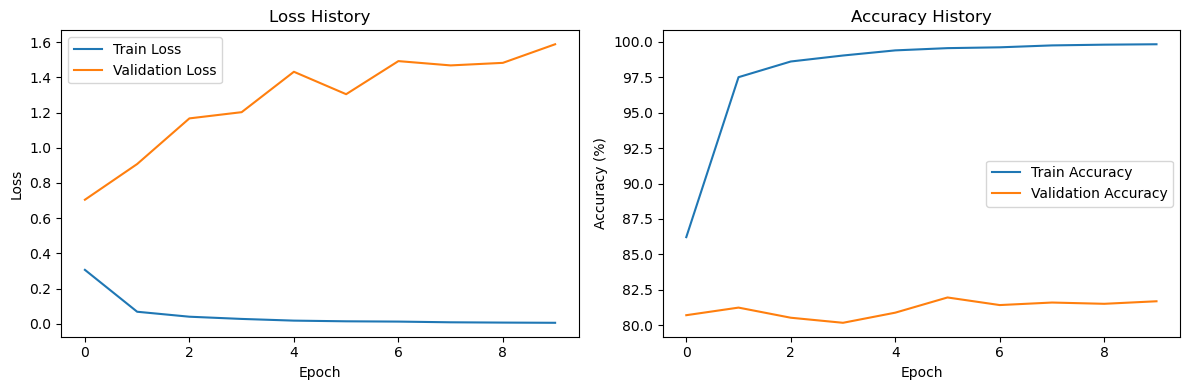

Early stopping at epoch 7


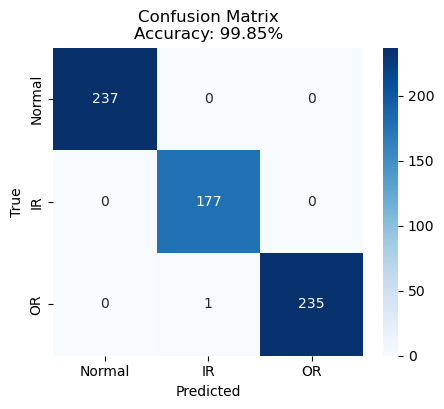

 - Model accuracy: 99.85%


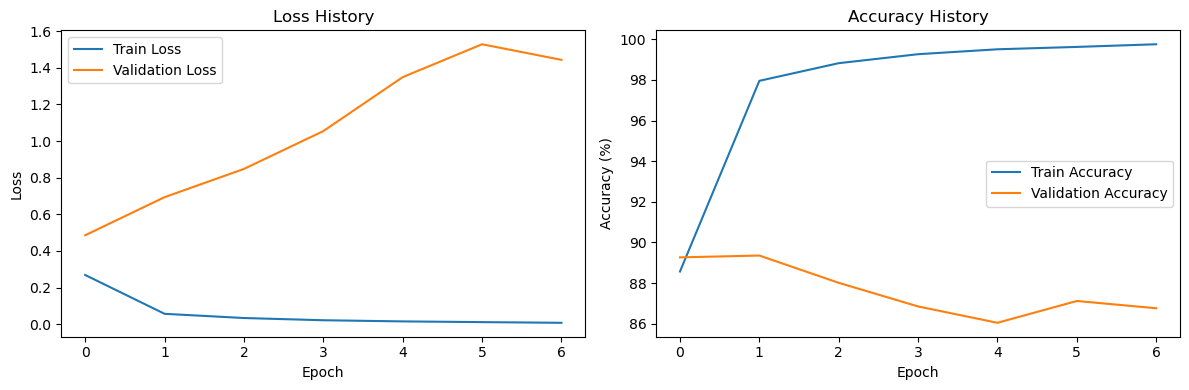

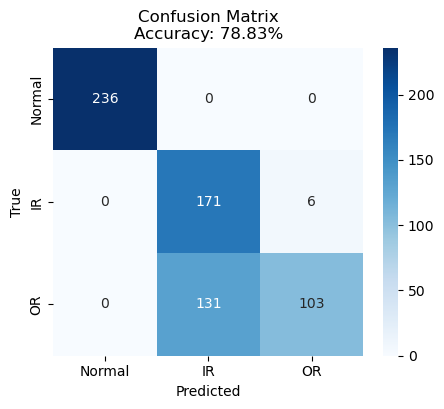

 - Model accuracy: 78.83%


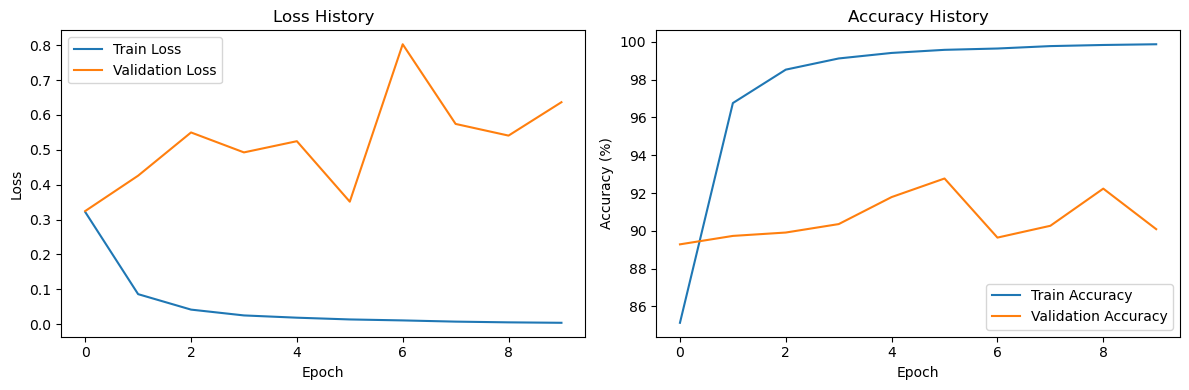

Early stopping at epoch 8


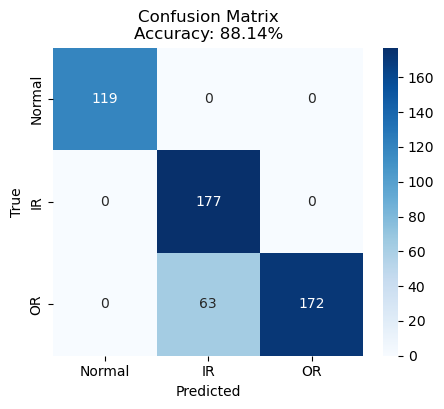

 - Model accuracy: 88.14%


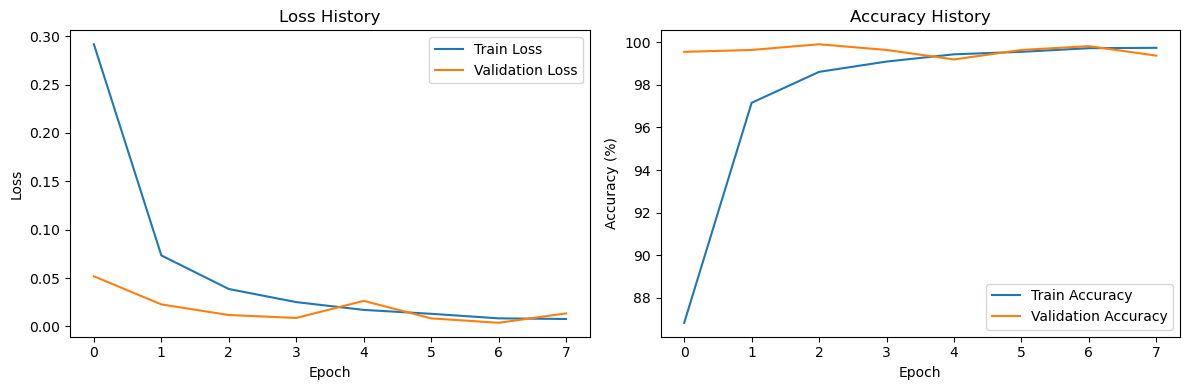

Early stopping at epoch 9


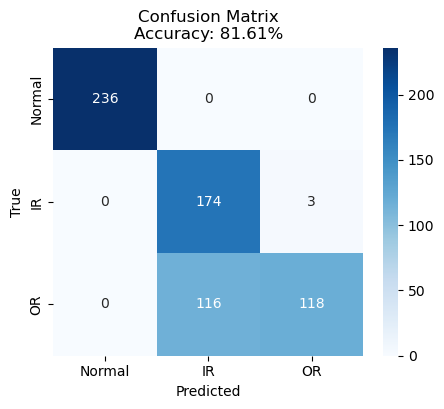

 - Model accuracy: 81.61%


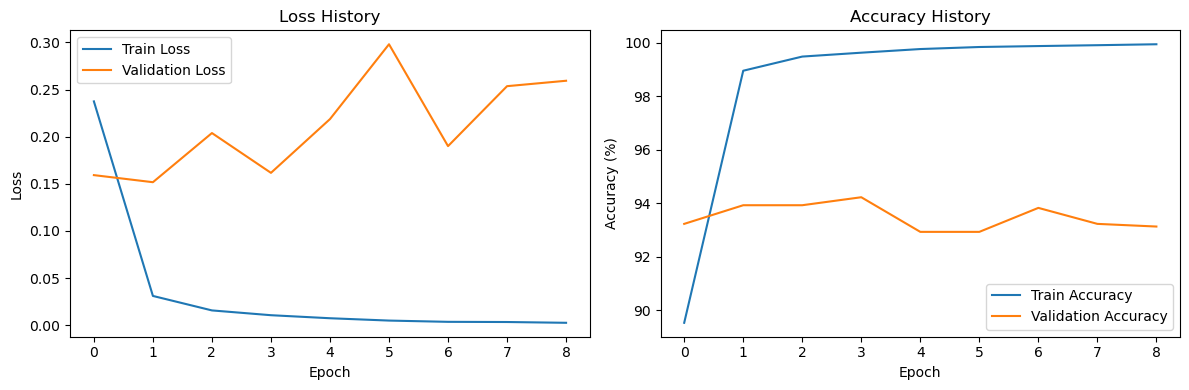

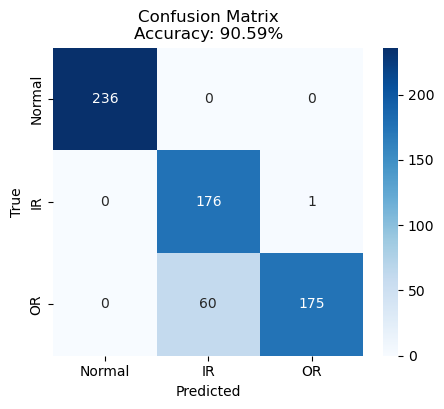

 - Model accuracy: 90.59%


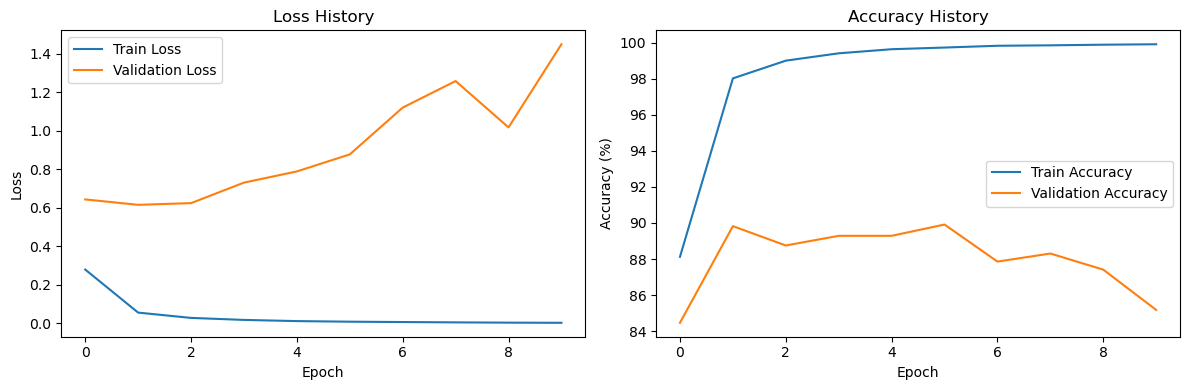

Early stopping at epoch 9


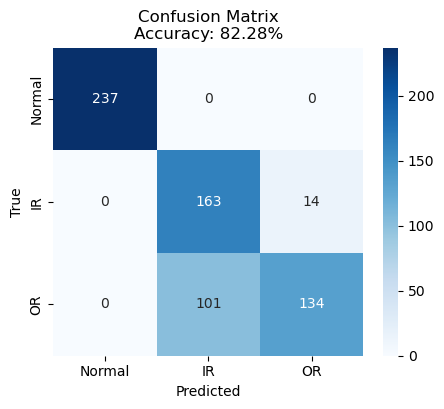

 - Model accuracy: 82.28%


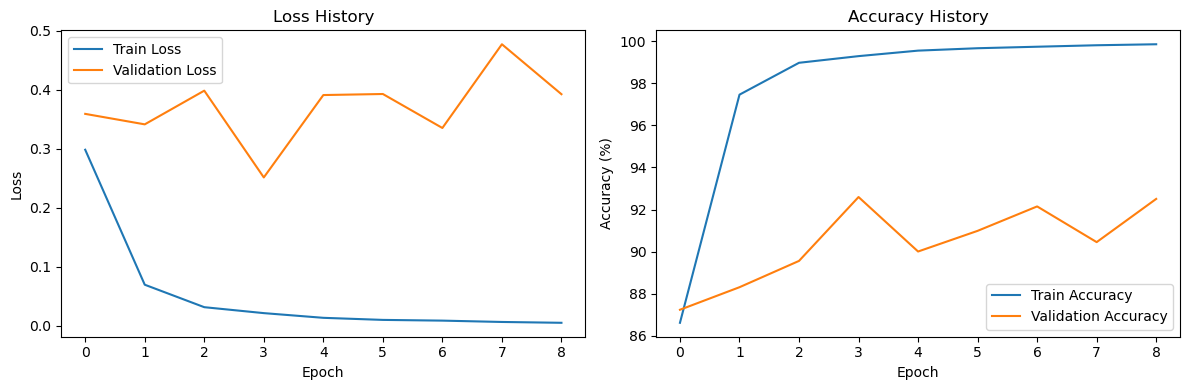

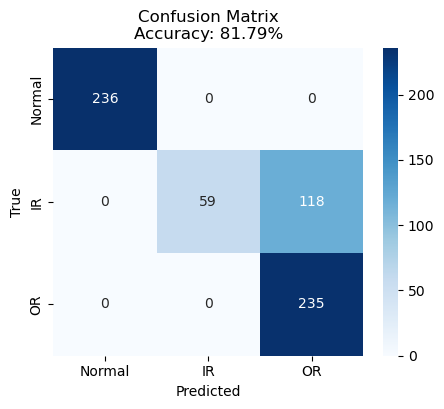

 - Model accuracy: 81.79%


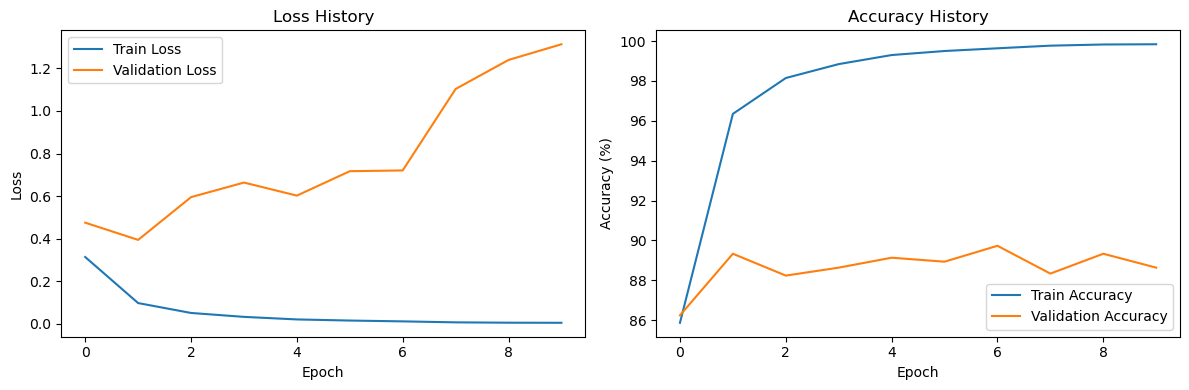

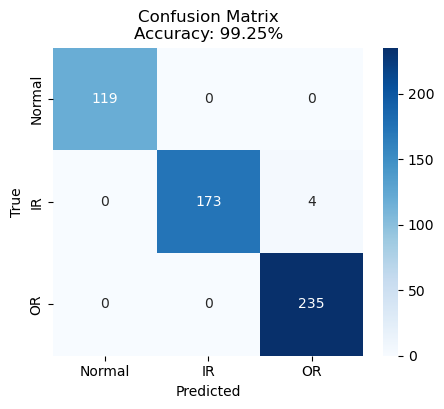

 - Model accuracy: 99.25%


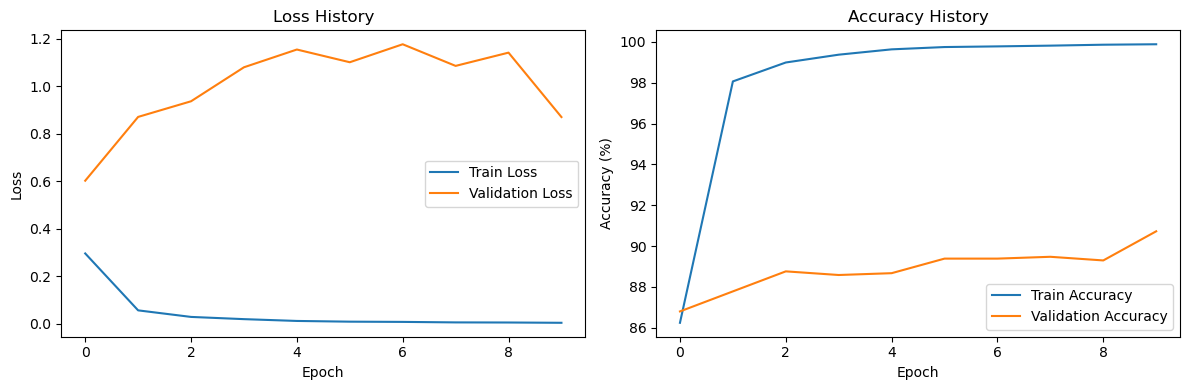

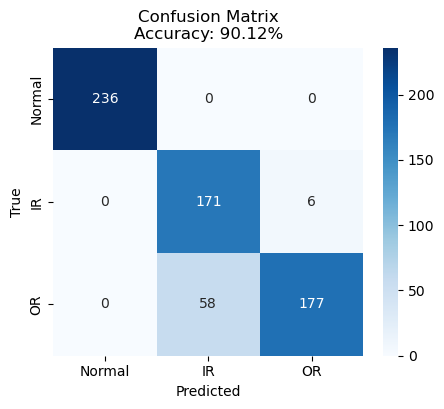

 - Model accuracy: 90.12%


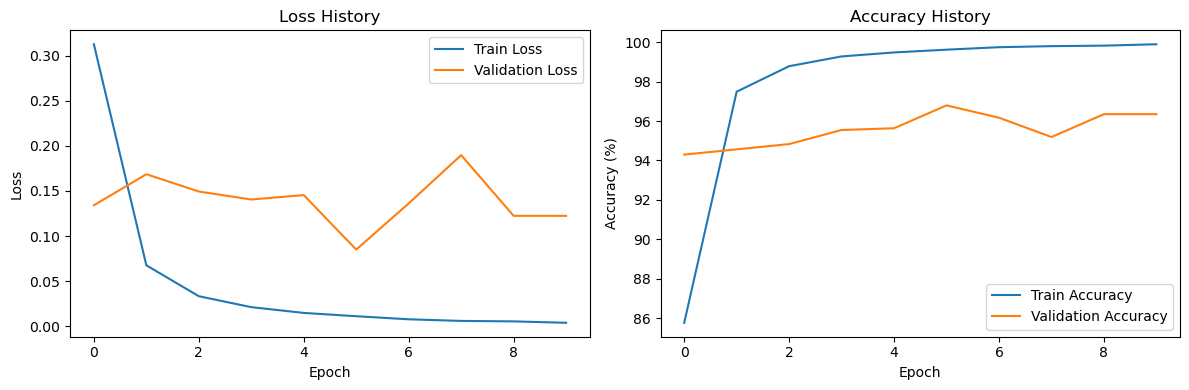

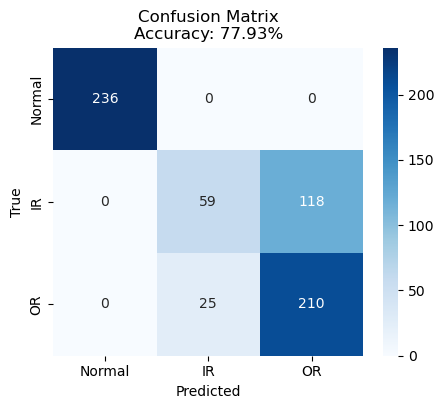

 - Model accuracy: 77.93%


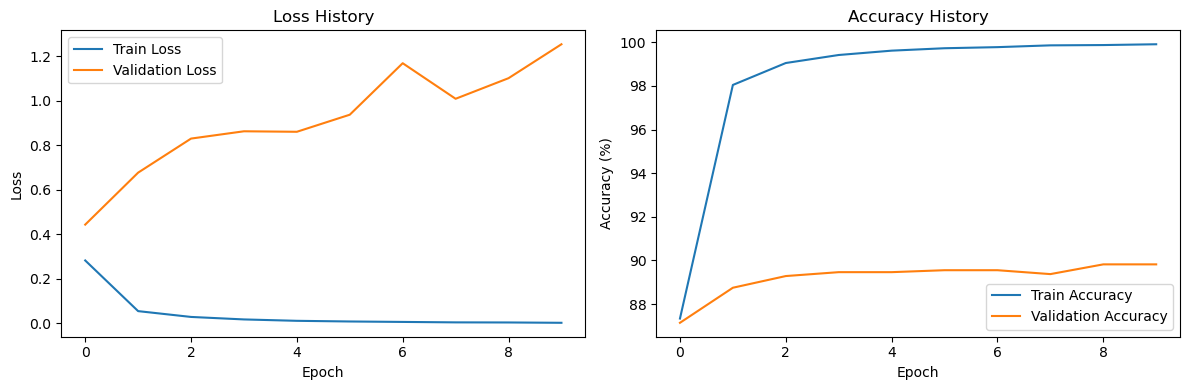

Early stopping at epoch 8


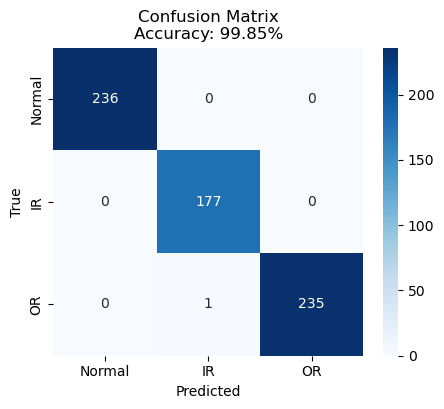

 - Model accuracy: 99.85%


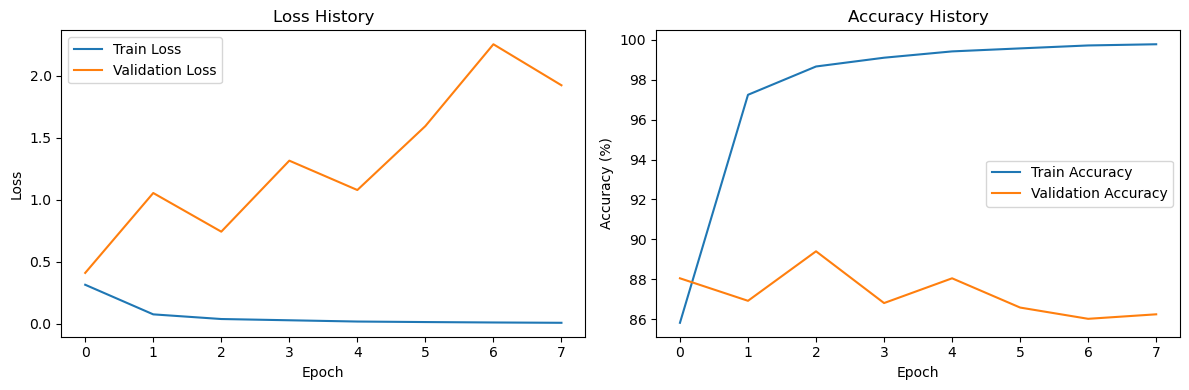

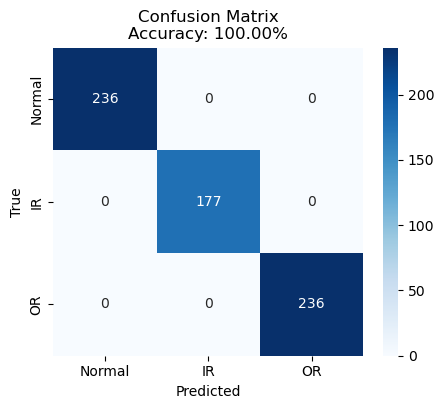

 - Model accuracy: 100.00%


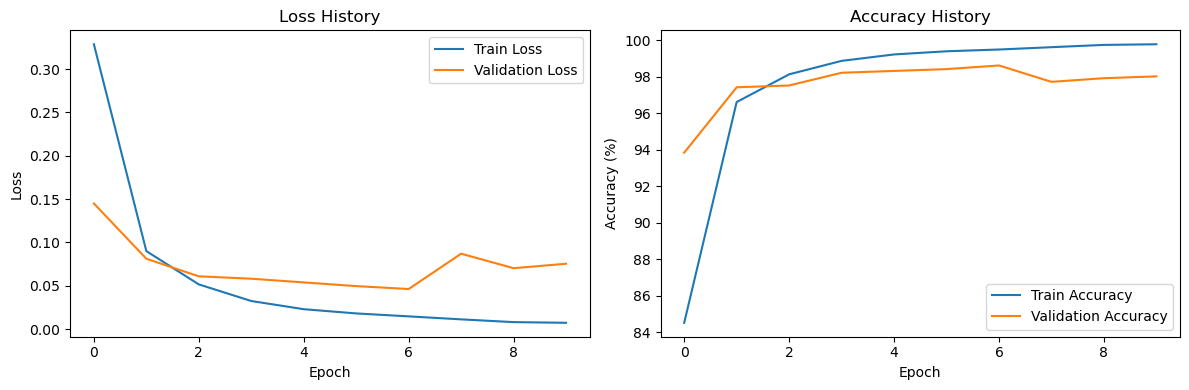

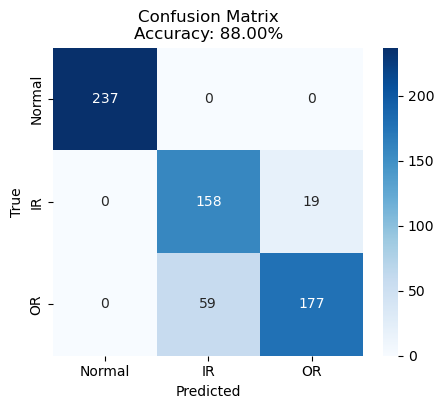

 - Model accuracy: 88.00%


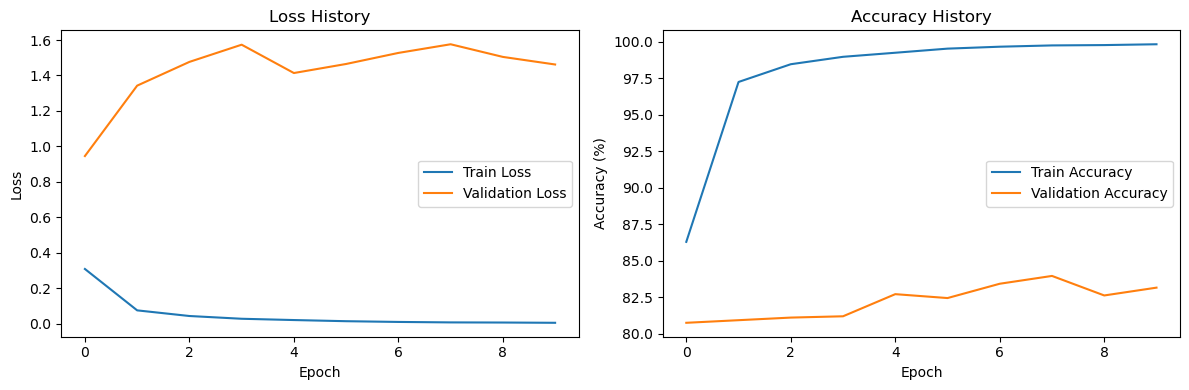

Early stopping at epoch 6


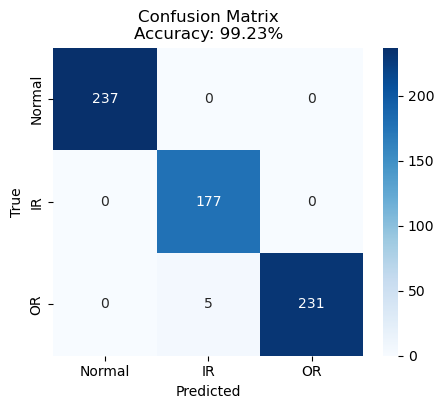

 - Model accuracy: 99.23%


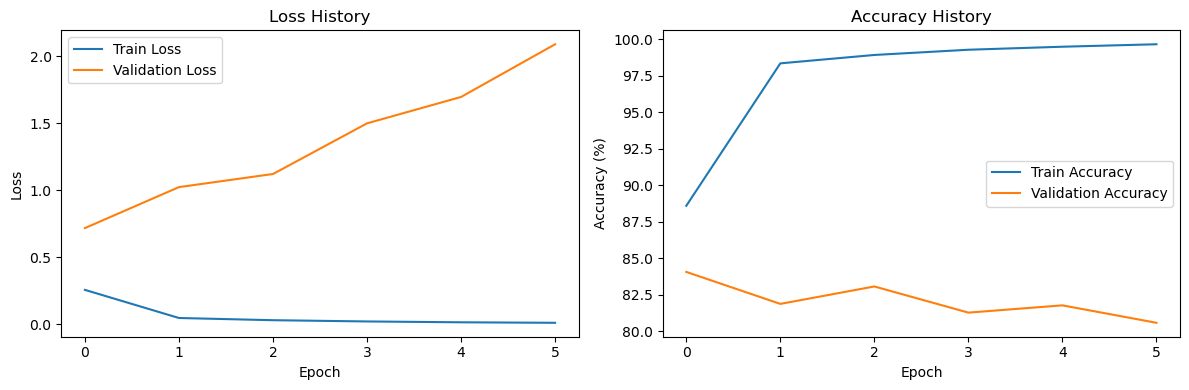

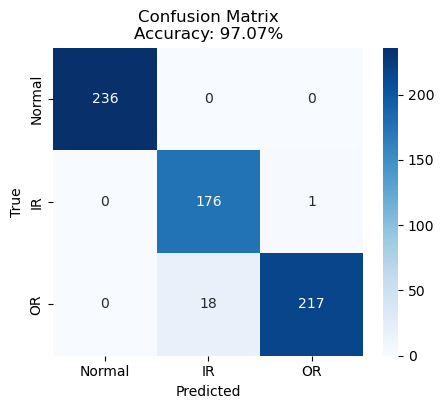

 - Model accuracy: 97.07%


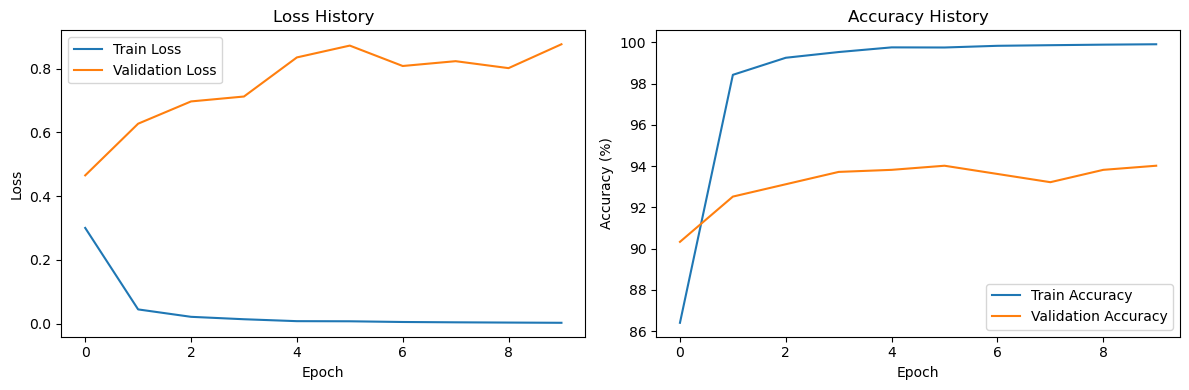

Early stopping at epoch 10


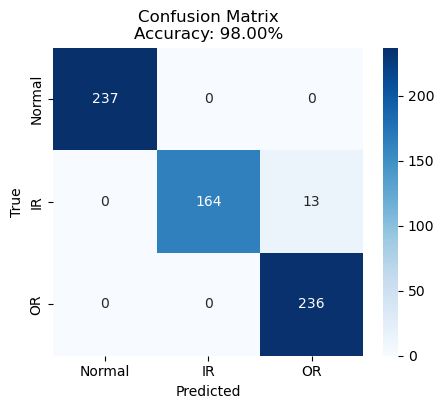

 - Model accuracy: 98.00%


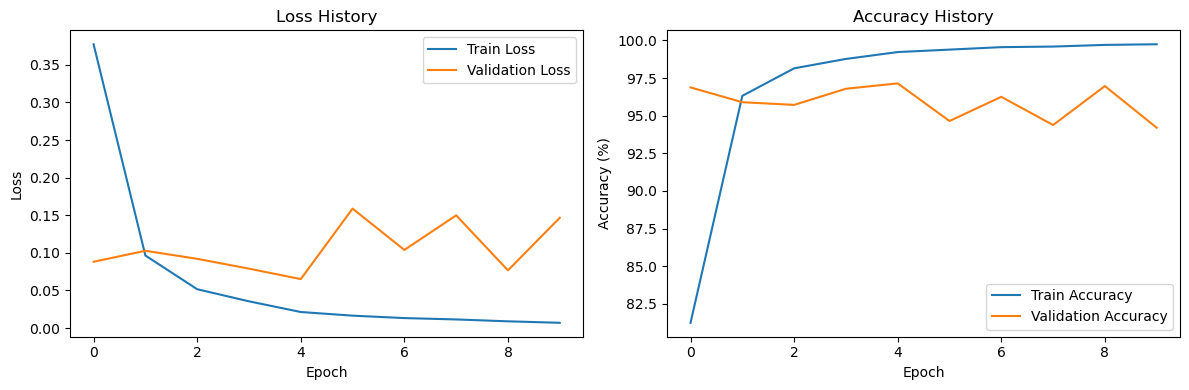

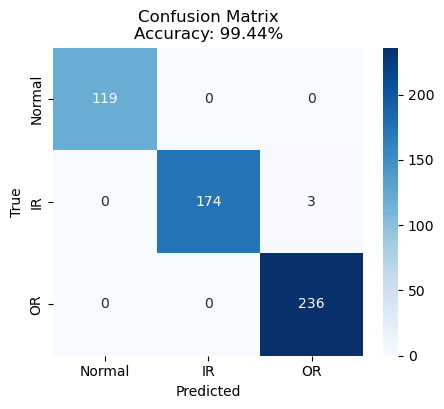

 - Model accuracy: 99.44%


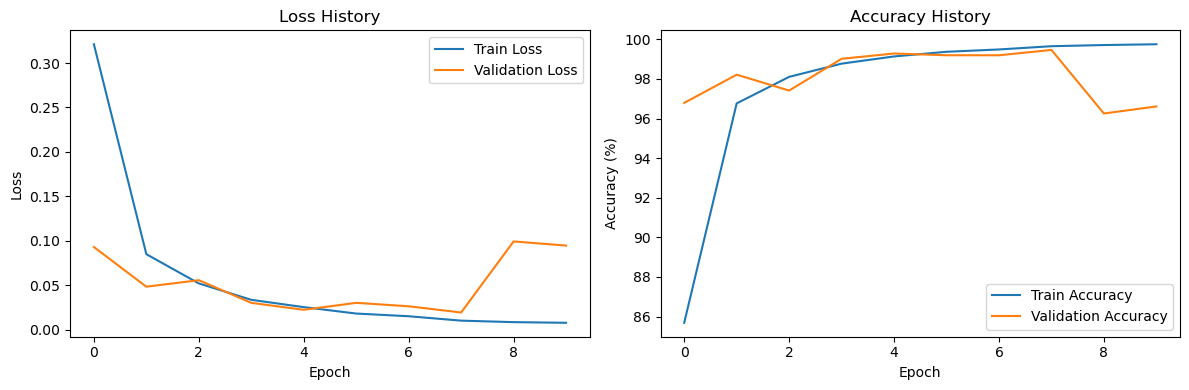

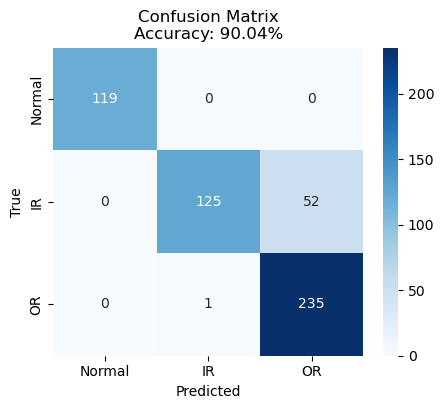

 - Model accuracy: 90.04%


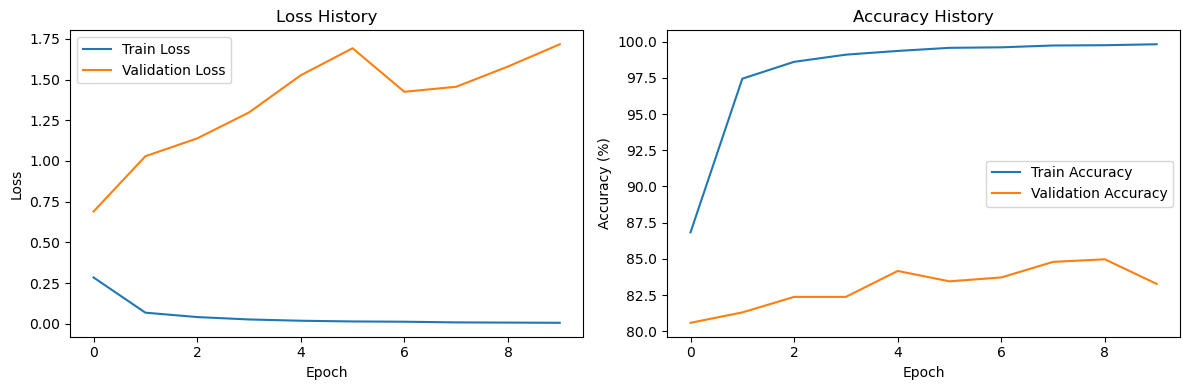

Mean accuracy: 0.9068295434271667
Std accuracy: 0.09474652690196055


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
from scipy.io import loadmat
import re
import random

# --- Import các module từ dự án của bạn ---
import cfg
from src import trainer, evaluate
from torch.utils.data import DataLoader, Dataset

# =====================================================================================
# PHẦN 1: ĐỊNH NGHĨA KIẾN TRÚC MOBILENETV3-SMALL (Đã điều chỉnh)
# =====================================================================================

class conv_block(nn.Module):
    """Khối Conv-BN-Activation tiêu chuẩn."""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1, activation=None):
        super().__init__()
        padding = kernel_size // 2
        self.activation_fn = None
        if activation == 'ReLU':
            self.activation_fn = nn.ReLU6(inplace=True)
        elif activation == 'H_swish':
            self.activation_fn = nn.Hardswish(inplace=True)
        
        layers = [
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm1d(out_channels)
        ]
        if self.activation_fn:
            layers.append(self.activation_fn)
        
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

class SE_block(nn.Module):
    """Squeeze-and-Excitation block."""
    def __init__(self, in_channel, ratio=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channel, in_channel // ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channel // ratio, in_channel, bias=False),
            nn.Hardsigmoid(inplace=True)
        )
    def forward(self, x):
        b, c, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

class bottleneck(nn.Module):
    """Khối Bottleneck của MobileNetV3."""
    def __init__(self, in_channels, kernel_size, expansion_size, out_channels, use_attention, activation, stride):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels

        self.conv_block = nn.Sequential(
            conv_block(in_channels, expansion_size, 1, activation=activation),
            conv_block(expansion_size, expansion_size, kernel_size, stride=stride, groups=expansion_size, activation=activation),
            SE_block(expansion_size) if use_attention else nn.Identity(),
            conv_block(expansion_size, out_channels, 1) # Lớp cuối không có activation
        )

    def forward(self, x):
        res = self.conv_block(x)
        if self.use_residual:
            res += x
        return res

class MobileNetV3_small_1D(nn.Module):
    def __init__(self, input_channels=1, num_classes=3):
        super().__init__()
        
        # QUYẾT ĐỊNH 1: Lớp đầu tiên chấp nhận input_channels=1
        self.features = nn.Sequential(
            conv_block(input_channels, 16, kernel_size=3, stride=2, activation='H_swish'),
            bottleneck(16, 3, 16, 16, True, 'ReLU', 2),
            bottleneck(16, 3, 72, 24, False, 'ReLU', 2),
            bottleneck(24, 3, 88, 24, False, 'ReLU', 1),
            bottleneck(24, 5, 96, 40, True, 'H_swish', 2),
            bottleneck(40, 5, 240, 40, True, 'H_swish', 1),
            bottleneck(40, 5, 240, 40, True, 'H_swish', 1),
            bottleneck(40, 5, 120, 48, True, 'H_swish', 1),
            bottleneck(48, 5, 144, 48, True, 'H_swish', 1),
            bottleneck(48, 5, 288, 96, True, 'H_swish', 2),
            bottleneck(96, 5, 576, 96, True, 'H_swish', 1),
            bottleneck(96, 5, 576, 96, True, 'H_swish', 1),
            conv_block(96, 576, 1, activation='H_swish')
        )
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # QUYẾT ĐỊNH 3: Sử dụng classifier tiêu chuẩn
        self.classifier = nn.Sequential(
            nn.Linear(576, 1024),
            nn.Hardswish(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)
        return x

# =====================================================================================
# PHẦN 2: LOGIC TẢI DỮ LIỆU VÀ HUẤN LUYỆN
# =====================================================================================

def get_label_from_path(file_path: Path) -> int:
    path_parts = file_path.parts
    if 'Normal' in path_parts: return 0
    elif 'IR' in path_parts: return 1
    elif 'OR' in path_parts: return 2
    return -1

def import_cwru_data_raw(file_keys: list, sample_length: int, base_path: str, overlapping_ratio: float = 0.0):
    all_samples, all_labels = [], []
    base_path_obj = Path(base_path)
    step = int(sample_length * (1 - overlapping_ratio))
    if step < 1: step = 1
    for key in file_keys:
        match = re.match(r'(\d+)(\w+)', key)
        if not match: continue
        file_num_str, data_key_suffix = match.groups()
        glob_pattern = f'{file_num_str}_*.mat'
        found_files = list(base_path_obj.rglob(glob_pattern))
        if not found_files: continue
        file_path = found_files[0]
        label = get_label_from_path(file_path)
        mat_data = loadmat(file_path)
        mat_key_zfill = f'X{file_num_str.zfill(3)}_{data_key_suffix}_time'
        mat_key_normal = f'X{file_num_str}_{data_key_suffix}_time'
        mat_key = mat_key_zfill if mat_key_zfill in mat_data else mat_key_normal
        if mat_key not in mat_data: continue
        time_series = mat_data[mat_key].flatten()
        for i in range(0, len(time_series) - sample_length + 1, step):
            all_samples.append(time_series[i : i + sample_length])
            all_labels.append(label)
    return np.array(all_samples), np.array(all_labels)

def data_import_raw(sample_length: int, overlapping_ratio: float, train_ratio=0.7, val_ratio=0.2):
    normal_files = ['97DE', '97FE', '98DE', '98FE', '99DE', '99FE', '100DE', '100FE']
    ir_files = ['211DE', '279DE', '274FE', '272DE', '272FE', '272BA', '209DE', '209FE', '210DE', '278DE', '278FE', '280DE', '280BA', '271DE', '271FE', '271BA', '276FE', '276BA', '277FE', '277BA', '212DE', '281DE', '275FE', '273DE', '273FE', '273BA']
    or_files = ['132DE', '146DE', '146FE', '146BA', '159DE', '312DE', '312FE', '315DE', '133DE', '147DE', '147FE', '147BA', '160DE', '317DE', '317FE', '317BA', '130DE', '131DE', '144DE', '144BA', '145DE', '145FE', '145BA', '156DE', '156FE', '310DE', '310FE', '309DE', '311DE', '311FE', '313DE', '313FE']
    data = [normal_files, ir_files, or_files]
    train_files, val_files, test_files = [], [], []
    for fault in data:
        random.shuffle(fault)
        n_samples = len(fault)
        train_end = int(train_ratio * n_samples)
        val_end = train_end + round(val_ratio * n_samples)
        train_files.extend(fault[:train_end]); val_files.extend(fault[train_end:val_end]); test_files.extend(fault[val_end:])
    X_train, Y_train = import_cwru_data_raw(train_files, sample_length, cfg.BASE_PATH, overlapping_ratio)
    X_val, Y_val = import_cwru_data_raw(val_files, sample_length, cfg.BASE_PATH, 0.0)
    X_test, Y_test = import_cwru_data_raw(test_files, sample_length, cfg.BASE_PATH, 0.0)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

class BearingDatasetRaw(Dataset):
    def __init__(self, X_data, Y_data, normalization=None):
        self.data = torch.from_numpy(X_data).float()
        self.labels = torch.from_numpy(Y_data).long()
        self.normalization = normalization
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.normalization == 'z-score':
            std = sample.std()
            if std > 1e-8: sample = (sample - sample.mean()) / std
        elif self.normalization == 'min-max':
            min_val, max_val = sample.min(), sample.max()
            range_val = max_val - min_val
            if range_val > 1e-8: sample = (sample - min_val) / range_val
        return sample.unsqueeze(0), self.labels[idx]

# =====================================================================================
# PHẦN 3: QUY TRÌNH HUẤN LUYỆN MOBILENETV3-SMALL
# =====================================================================================

if __name__ == '__main__':
    # 1. Thiết lập các tham số
    # QUYẾT ĐỊNH 2: Sử dụng độ dài đầu vào 2048
    MOBILENET_INPUT_LENGTH = 2048
    TRAIN_OVERLAPPING_RATIO = 0.95
    NORMALIZATION_METHOD = None 

    accuracy_list= []
    for i in range(30):
        trainer.set_seed(i)
        # 2. Tải và chuẩn bị dữ liệu
        X_train, Y_train, X_val, Y_val, X_test, Y_test = data_import_raw(
            sample_length=MOBILENET_INPUT_LENGTH,
            overlapping_ratio=TRAIN_OVERLAPPING_RATIO
        )
        
        train_dataset = BearingDatasetRaw(X_train, Y_train)
        val_dataset = BearingDatasetRaw(X_val, Y_val)
        test_dataset = BearingDatasetRaw(X_test, Y_test)
        
        train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)

        # 3. Khởi tạo mô hình, optimizer, scheduler, loss
        model = MobileNetV3_small_1D(input_channels=1, num_classes=cfg.NUM_CLASSES)
        model.to(cfg.DEVICE)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=cfg.NUM_EPOCHS, eta_min=1e-5 * 1e-2
        )

        trained_model, history = trainer.train_model(
            model=model, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            criterion=criterion, 
            optimizer=optimizer, 
            output_name='mobilenetv3_small_best.pth', # Tên file lưu model
            scheduler=scheduler, 
            num_epochs=10, 
            device=cfg.DEVICE
        )
        accuracy = evaluate.plot_confusion_matrix(trained_model, test_loader, 'cpu', cfg.CLASS_NAMES)
        accuracy_list.append(accuracy)
        evaluate.plot_history(history)

    print('='*20)
    print('Mean accuracy:', np.mean(accuracy_list))
    print('Std accuracy:', np.std(accuracy_list))